In [1]:
import pickle
import os
import h5py
import numpy as np

### Load data

In [3]:
beta_path_suffix = ["", # this is beta 0.5
                    "beta0",
                    "beta1",
                    "beta0_25",
                    "beta0_75",
                   ][1]

In [4]:
data_path = "/analysis/ritter/projects/Methods/LRP/data/rieke-copy1/2Node_trial0/" + beta_path_suffix

hippo_file = h5py.File('/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_ID_Hippocampus.h5', 'r')
rs_per_area_LRP = dict()
rs_per_area_GB = dict()
cases = ['AD', 'HC', 'TP', 'TN', 'FP', 'FN']
for case in cases:
    with open(os.path.join(data_path, "LRP_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
            rs_per_area_LRP.update({case: pickle.load(file)})

    with open(os.path.join(data_path, "GB_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
            rs_per_area_GB.update({case: pickle.load(file)})

In [5]:
# idcs are the same for both LRP and GB
idcs = np.array([p_idx for p_idx, _ in rs_per_area_LRP['TP']["Hippocampus"]])

# True values
AD_Hvals = np.array(list(hippo_file['Hippocampus']))[idcs]
# Relevance values (LRP)
AD_Hrels = np.array([r for _, r in rs_per_area_LRP['TP']["Hippocampus"]])
# Sensitivity values (GB)
AD_Hsens = np.array([r for _, r in rs_per_area_GB['TP']["Hippocampus"]])


mask = ~np.isnan(AD_Hvals)

actual_LRP_corrcoef = np.corrcoef(AD_Hvals[mask], AD_Hrels[mask])[1, 0]
actual_GB_corrcoef = np.corrcoef(AD_Hvals[mask], AD_Hsens[mask])[1, 0]

print("LRP: ", actual_LRP_corrcoef, ".")
print("GB: ", actual_GB_corrcoef, ".")

LRP:  -0.5603004848271849 .
GB:  0.09615624758406163 .


### Permutation test

In [7]:
from copy import copy


In [8]:
idcs = {case: np.array([p_idx for p_idx, _ in rs_per_area_LRP[case]["Hippocampus"]]) for case in cases}

AD_Hvals_case = {case: np.array(list(hippo_file['Hippocampus']))[idcs[case]] for case in cases}

AD_Hrels_case = {case: np.array([r for _, r in rs_per_area_LRP[case]["Hippocampus"]]) for case in cases}
AD_Hsens_case = {case: np.array([r for _, r in rs_per_area_GB[case]["Hippocampus"]]) for case in cases}



LRP_coeff_rand = []
GB_coeff_rand = []
for i in range(1000):
    idcss = copy(idcs['TP'])
    np.random.shuffle(idcss)
    AD_Hvals = np.array(list(hippo_file['Hippocampus']))[idcss]
    mask = ~np.isnan(AD_Hvals)

    LRP_corrcoef = np.corrcoef(AD_Hvals[mask], AD_Hrels[mask])[1, 0]
    GB_corrcoef = np.corrcoef(AD_Hvals[mask], AD_Hsens[mask])[1, 0]
    
    LRP_coeff_rand.append(LRP_corrcoef)
    GB_coeff_rand.append(GB_corrcoef)
    


print("LRP bigger than observed: ", np.sum(actual_LRP_corrcoef < np.array(LRP_coeff_rand)), ".")
print("GB smaller than observed: ", np.sum(actual_GB_corrcoef > np.array(LRP_coeff_rand)), ".")

print("LRP random order mean: ", np.mean(LRP_coeff_rand), ".")
print("LRP random order std: ", np.std(LRP_coeff_rand), ".")
print("GB random order mean: ", np.mean(GB_coeff_rand), ".")
print("GB random order std: ", np.std(GB_coeff_rand), ".")

LRP bigger than observed:  1000 .
GB smaller than observed:  795 .
LRP random order mean:  -0.010661391220588571 .
LRP random order std:  0.13238323601255558 .
GB random order mean:  0.011859570091072004 .
GB random order std:  0.13538990822633692 .


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

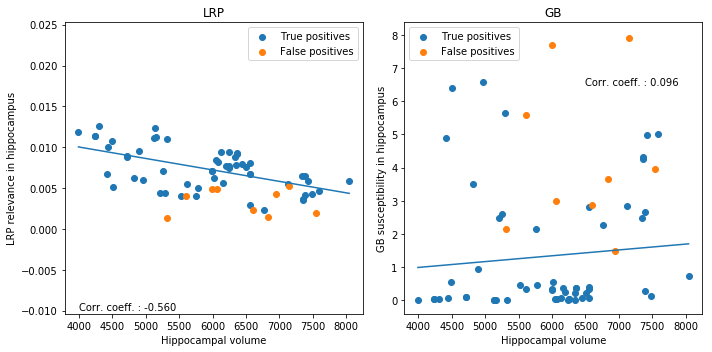

In [10]:
sort_idcs = np.array(sorted([(i, val) for i, val in enumerate(AD_Hvals_case['TP']) if not np.isnan(val)], key=lambda x: x[1]), dtype=int)[:, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for case in ['TP', 'FP']:
    ax1.scatter(AD_Hvals_case[case], AD_Hrels_case[case], label='True positives' if case == 'TP' else 'False positives')
for case in ['TP', 'FP']:
    ax2.scatter(AD_Hvals_case[case], AD_Hsens_case[case], label='True positives' if case == 'TP' else 'False positives')
ax1.legend()
ax2.legend()
ax1.set_ylabel('LRP relevance in hippocampus')
ax1.set_xlabel('Hippocampal volume')
ax2.set_xlabel('Hippocampal volume')
ax2.set_ylabel('GB susceptibility in hippocampus')
z = np.polyfit(AD_Hvals_case['TP'][sort_idcs], AD_Hrels_case['TP'][sort_idcs], 1)
linear = lambda x: z[1] + z[0]*x
mini, maxi = AD_Hvals_case['TP'][sort_idcs][0], AD_Hvals_case['TP'][sort_idcs][-1]
ax1.plot(np.linspace(mini, maxi, 2), linear(np.array([mini, maxi])))
z = np.polyfit(AD_Hvals_case['TP'][sort_idcs], AD_Hsens_case['TP'][sort_idcs], 1)
linear = lambda x: z[1] + z[0]*x
mini, maxi = AD_Hvals_case['TP'][sort_idcs][0], AD_Hvals_case['TP'][sort_idcs][-1]
ax2.plot(np.linspace(mini, maxi, 2), linear(np.array([mini, maxi])))

ax1.text(4000, -0.010, 'Corr. coeff. : {:.3f}'.format(actual_LRP_corrcoef))
ax2.text(6500, 6.5, 'Corr. coeff. : {:.3f}'.format(actual_GB_corrcoef))

ax1.set_title('LRP')
ax2.set_title('GB')
fig.tight_layout()
# fig.savefig("./correlation.pdf")

Text(0, 0.5, 'corrcoef')

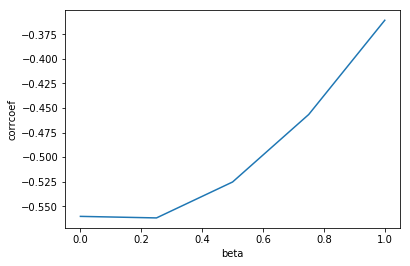

In [11]:
# Correlation values for different betas
corrs = [-0.5603004848271849, -0.5618695011449486, -0.5253121992485645, -0.45670034315239927, -0.36082410679630594]

plt.plot([0, .25, .5, .75, 1], corrs)

plt.xlabel('beta')
plt.ylabel('corrcoef')
